# Lab 7: Cross Validation and Hyperparameter Search

In this lab you'll use *cross validation* to do *hyperparameter search*, a particular form of *model selection*.
* **Cross validation** is a procedure for *estimating* the test-time performance of a given model. Cross validation does not need access to any test data. Instead, it works by holding out some of the training data and using if it were testing data. In this lab we will focus on *K*-fold cross validation, where the training data is divided into *K* equally-sized chunks and each chunk gets a turn "pretending" to be a test set. This will be explained.
* **Model selection** procedures try to select a "best" model from among many alternatives. The best model is usually the one that we can *expect* to have the best test-time performance. Since cross validation lets us *estimate* the test-time performance, many model selection procedures rely on cross validation as a subroutine.
* **Hyperparameter search** is a particular *model selection* procedure that focuses on selecting one model from a family of related models. Hyperparameter search can therefore be seen as a "model tuning" procedure. For example, we can define all *DecisionTreeClassifiers* with *max_depth* $\in\{1,\ldots,1000\}$ as being a "family" with 1000 possible members to choose from. Hyperparameter search would find a particular setting for *max_depth* that is estimated to have the best possible test-time performance (*not* necessarily the best training performance).  A good hyperparameter search procedure will find good hyperparameters (hyperparameters estimated to have good test-time performance) using very few "attempts", since each attempt requires performing cross validation and this can be computationally demanding.

The goal is to understand what cross validation is, how it is used as a subroutine within a hyperparameter search procedure. You will be asked to try two different hyperparameter search procedures: grid search and random search.

**Run the code cell below** to import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.svm               # For SVC
import sklearn.tree              # For DecisionTreeClassifier
import sklearn.metrics           # For accuracy_score
import sklearn.model_selection   # For cross_val_score, GridSearchCV, RandomizedSearchCV
import scipy
import scipy.stats               # For reciprocal distribution
import warnings
from numpy import genfromtxt
from sklearn.preprocessing import scale
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Understanding Cross Validation

Exercise 1.1&ndash;1.3 ask you to load and preprocess the training data (**exercise1_train.csv**), then split the data to training set and held-out test set (**[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**), then finally compare how *K*-fold cross validation can estimate the held-out test performance of a model.

**Run the code cell below** to define some functions for plotting data and model. 

In [2]:
exercise1_extent = (-3, 4, -3, 4)

def plot_decision_function(model):
    """
    Plots the decision function of a model as a red-blue heatmap.
    The region evaluated, along with x and y axis limits, are determined by 'extent'.
    """
    x1min, x1max ,x2min, x2max = exercise1_extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max, 200))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.decision_function(X).reshape(x1.shape)
    plt.imshow(-y, extent=exercise1_extent, origin='lower', vmin=-1, vmax=1, cmap='bwr', alpha=0.5, interpolation='nearest')
    if y.min() < 0 and y.max() > 0:
        plt.contour(x1, x2, y, levels=[0], colors=['k'])  # Decision boundary
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    
def plot_data(X, y):
    """Plots the data from Exercise 1"""
    plt.scatter(*X[y==0].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim(exercise1_extent[:2])
    plt.ylim(exercise1_extent[2:])
    plt.gca().set_aspect('equal')    

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.1 &mdash;  Load, re-scale, and plot full data set

Start by loading the data from exercise1_train.csv, then seperate the data and also pre-process the data to the right scale, and plot the data using **plot_data()** function. 

Your plot should look like the figure below.

![image](img/data.png)


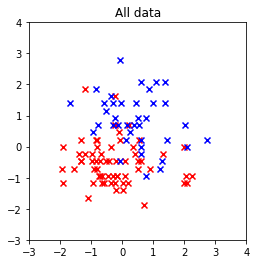

In [3]:
data = genfromtxt('exercise1.csv', delimiter=',',skip_header=1)

X = scale(data[:,0:2])
y = data[:,2]

plot_data(X, y)
plt.title('All data');
# Your code here. Aim for 6-8 lines.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.2 &mdash;  Split data to training and testing
In this exercise, you should use  **[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)** to split the data from Exercise 1.1 to two groups: a training set, and a held-out test set. Use *random_state*=0. For this exercise, you should explicitly ask for a 70/30 split (70% training data, 30% testing data). Plot the two data sets side-by-side, using the *subplot* function of Matplotlib.

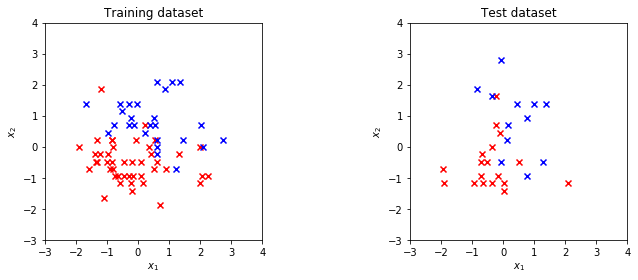

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_data(X_train, y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Training dataset')
plt.subplot(1,2,2)
plot_data(X_test, y_test)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Test dataset');
# Your code here. Aim for 6-10 lines.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Exercise 1.3 &mdash; Use *K*-fold cross-validation to *estimate* held-out performance

As a rule, data marked as a "test set" should ALMOST NEVER be used for training, or even for model selection. All modeling choices (parameters, best model) must be made based on training data, ONLY. Otherwise you will very likely fool yourself, or others, into thinking your system will perform well on held-out data when it will not. 

"Peeking" at the test data, directly or indirectly, or even measuring the performance on test data too often, is even considered cheating. In fact, at least <a href="https://www.cio.com/article/2935233/baidu-fires-researcher-involved-in-ai-contest-flap.html">one well-known machine learning scientist was <b>fired from his job</b></a> for trying to tune hyperparameters directly to the test data.


***K*-fold cross validation** is a specific procedure for estimating held-out performance using only the training set. It creates *K* different (training, validation) splits and then averaging the validation performance measured on each one. (Beware that scikit-learn's [desciption of cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) sometimes refers to the *K* individual validation sets as "test sets" so this can be confusing since they are not really validation sets.) The *K*-fold cross validation procedure is depicted below. When there are *K* splits the result is *K* different performance estimates, one for each of the held-out folds.
<img src="img/k-fold.png" width="550">

(Image source: https://scikit-learn.org/stable/modules/cross_validation.html)

Note that the "test data" depicted above is not needed for the cross validation procedure itself, and is only used as an (optional) final performance evaluation, after the model selection procedure.

**Write a few lines of code** to
1. train a *DecisionTreeClassifier* with *max_depth*=10
2. print the accuracy on the training set and test set from Exercise 1.2
2. print the *K*-fold cross validation accuracy for each $K \in \{2,\ldots,9\}$.

Use the **[sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** function or, equivalently, the **[score](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score)** method of your *DecisionTreeClassifier* to compute the training and testing accuracies.

Use the **[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)** function to do the cross validation. It will return an array of *K* values, so you need to average them to get an overall estimate.

Your code should print output that looks like this:
```
training accuracy:           100.0%
held-out accuracy (testing):  ??.?%
held-out accuracy (2-fold):   ??.?%
held-out accuracy (3-fold):   ??.?%
held-out accuracy (4-fold):   ??.?%
held-out accuracy (5-fold):   ??.?%
held-out accuracy (6-fold):   ??.?%
held-out accuracy (7-fold):   ??.?%
held-out accuracy (8-fold):   ??.?%
held-out accuracy (9-fold):   ??.?%
```

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

clf = sklearn.tree.DecisionTreeClassifier(random_state=0,max_depth=10)
clf.fit(X_train, y_train)

print('training accuracy:',clf.score(X_train, y_train)*100,'%')
print('held-out accuracy (testing):',"%.1f" % (clf.score(X_test, y_test)*100),'%')

for i in range(2, 10):
    cv = KFold(n_splits=i)
    print('held-out accuracy ('+ str(i)+'-fold)',"%.1f" % np.mean(cross_val_score(clf, X_train, y_train, cv=cv)*100)+'%')
# Your code here. Aim for 6-10 lines.

training accuracy: 100.0 %
held-out accuracy (testing): 76.7 %
held-out accuracy (2-fold) 78.6%
held-out accuracy (3-fold) 77.1%
held-out accuracy (4-fold) 77.3%
held-out accuracy (5-fold) 81.4%
held-out accuracy (6-fold) 83.0%
held-out accuracy (7-fold) 82.9%
held-out accuracy (8-fold) 80.2%
held-out accuracy (9-fold) 82.9%


Ask yourself: are the *K*-fold cross validation accuracies a reasonable estimate of the testing accuracy? Are they at least a better estimate than *training* accuracy?

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Hyperparameter search

Hyperparameter search is a particular kind of model selection, where we tune the parameters that are normally considered "fixed" (constant) during training itself.

Exercise 2.1 asks you to plot the SVM model with different hyperparameters, this would help you to visualize the grid of hyperparameters.

Exercise 2.2 asks you to perform grid search using **[sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)**

Exercise 2.3 asks you to perform random hyperparameter search

Exercise 2.4 asks you to evaluate the model selected from exercise 1.4 and 1.5 on the held-out test set



<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.1 &mdash; Visualize a grid of hyperparameters

In this exercise, you need to train an RBF SVM on the training data using different hyperparameter settings. The specific hyperparameters that you will inspect are *C* (the slack penalty) and the *gamma* (the RBF kernel spread).

To specify a "grid" of values, it is enough to specify the specific "ticks" we'll enumerate along each dimension. For example, if we specified that *C* took values from $\{C_1, C_2\}$ and *gamma* took values from $\{\gamma_1, \gamma_2, \gamma_3\}$ then we have specified the grid of hyperparameter values to try:

$$
\begin{matrix}
(C_1,\gamma_1) & (C_1,\gamma_2) & (C_1,\gamma_3)\\
(C_2,\gamma_1) & (C_2,\gamma_2) & (C_2,\gamma_3)
\end{matrix}
$$

Follow the steps for the code cells below.

**Step 1. Create a 4x4 grid made from 4 distinct *C* values and 4 distinct *gamma* values.**

The values should be "logarithmically spaced", i.e., equally spaced on a logarithmic scale. Use **[numpy.logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html)** to do this. For example, if you choose *C* values to be taken from $[1, 10, 100, 1000]$, these numbers are logarithmically spaced, not uniformly spaced. 

Why do we want logarithmic spacing? Because the *C* and *gamma* hyperparameters are sensiive over *orders of magnitude* and we don't know which order of magnitude is right for training on this data set.

In [6]:
C_range = np.logspace(0, 3, 4)
gamma_range = np.logspace(-2, 1, 4)

print('C_range:', C_range)
print('gamma_range:', gamma_range)

# Your code here. Aim for 2 lines, plus lines for printing the values, if it helps you.

C_range: [   1.   10.  100. 1000.]
gamma_range: [ 0.01  0.1   1.   10.  ]


**Step 2. Print the training accuracy of an RBF SVM for each setting in the grid**

Use for-loops to train an RBF SVM for each combination of (*C*, *gamma*) in your grid, using the variables you already created in the previous code cell. Train the SVMs on the *X_train* and *y_train* data from exercise 1.2.

The output of your code cell should be something like:
```
72.9% training accuracy for C=1.0 gamma=0.01
88.6% training accuracy for C=1.0 gamma=0.10
90.0% training accuracy for C=1.0 gamma=1.00
94.3% training accuracy for C=1.0 gamma=10.00
88.6% training accuracy for C=10.0 gamma=0.01
...
```
Based on your printed training accuracies, would you be able to guess which of these settings of (*C*, *gamma*) might work best on new test data?

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

C_range = np.logspace(0, 3, 4)
gamma_range = np.logspace(-2, 1, 4)

for C in C_range:
    for gamma in gamma_range:
        clf = SVC(kernel='rbf',C=C, gamma=gamma,random_state=0).fit(X_train, y_train)
        print("%.1f" % (clf.score(X_train, y_train)*100)+'%','training accuracy for C='+str(C), ' gamma='+str(gamma))

72.9% training accuracy for C=1.0  gamma=0.01
88.6% training accuracy for C=1.0  gamma=0.1
90.0% training accuracy for C=1.0  gamma=1.0
94.3% training accuracy for C=1.0  gamma=10.0
88.6% training accuracy for C=10.0  gamma=0.01
88.6% training accuracy for C=10.0  gamma=0.1
92.9% training accuracy for C=10.0  gamma=1.0
98.6% training accuracy for C=10.0  gamma=10.0
87.1% training accuracy for C=100.0  gamma=0.01
90.0% training accuracy for C=100.0  gamma=0.1
92.9% training accuracy for C=100.0  gamma=1.0
100.0% training accuracy for C=100.0  gamma=10.0
87.1% training accuracy for C=1000.0  gamma=0.01
90.0% training accuracy for C=1000.0  gamma=0.1
97.1% training accuracy for C=1000.0  gamma=1.0
100.0% training accuracy for C=1000.0  gamma=10.0


**Step 3. Plot the decision function for each setting in the grid**

Repeat step 2 but instead of printing accuracies you should instead plot the data (use **plot_data**) and the decision function of the trained SVM model (use **plot_decision_function**). You must create a single figure with 16 subplots arranged in a 4x4 grid, one for each (*C*, *gamma*) hyperparameter setting.

The top-left quadrant (the first 2x2 subplots) should look like the plot below.

![image](img/SVM-CV.png)

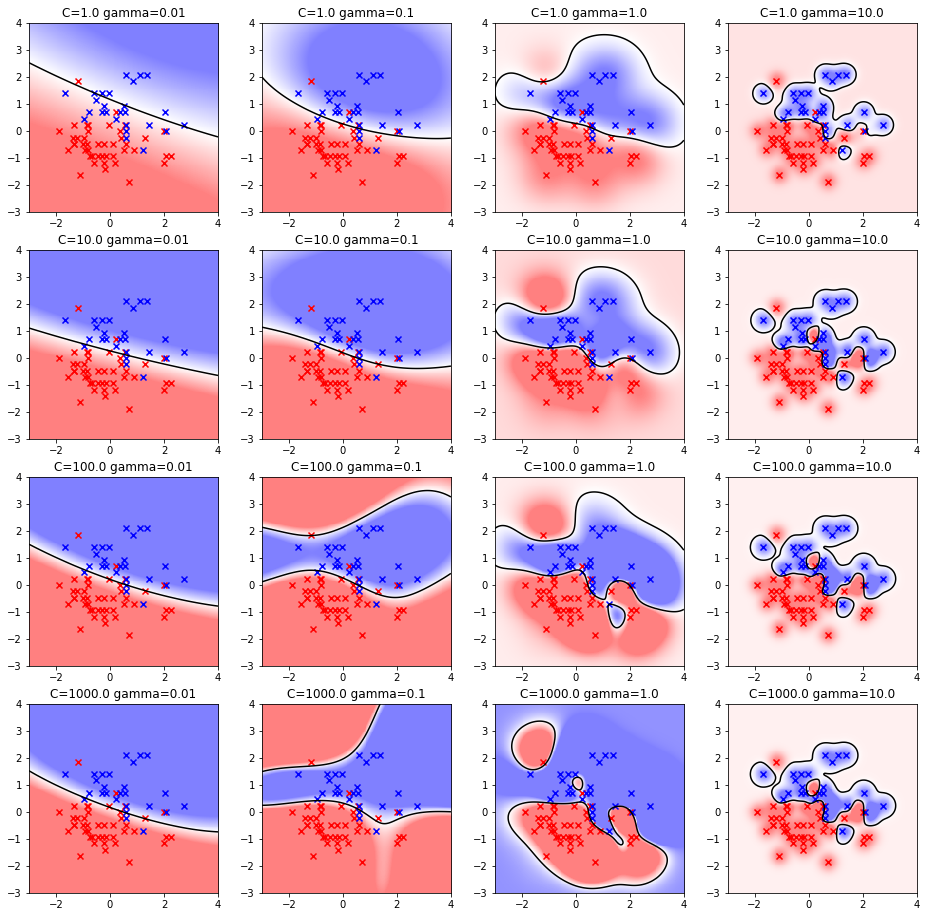

In [8]:
plt.figure(figsize=(16, 16))
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        clf = SVC(kernel='rbf',C=C_range[i], gamma=gamma_range[j], random_state=0).fit(X_train, y_train)
        
        plt.subplot(4, 4, 4*i + j+1)
        plt.title('C='+str(C_range[i])+' gamma='+str(gamma_range[j]))
        plot_data(X_train, y_train)
        plot_decision_function(clf)
# Your code here. Aim for 9-13 lines.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.2 &mdash; Grid hyperparameter search 

In this exercise, you should use the [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to perform a grid hyperparameter search (use the same grid of hyperparameters from *Exercise 2.1*) with the use of 3-fold cross validation. 

In particular, you should do the following:
1. Create an **SVC** object to serve as a prototype of the kind of model you wish to train. Make it an RBF SVM.
2. Define the **param_grid** argument to give **GridSearchCV**. This is a dictionary of the form *{ hyperparameter_name: array_of_possible_values }*. For example you could make a variable `param_grid = { 'C': ..., 'gamma': ...}` where `...` are the arrays of values you created early on in Exercise 2.1.
3. Create a **GridSearchCV** object, passing your prototype SVM object and your param_grid as arguments.
  * Set **verbose=1**, this will tell the function to print out more information of the grid search, and helps you to understand.  
  * Use the **cv** parameter to specify 3-fold cross validation
4. Call **fit** on the **GridSearchCV** object to perform the grid search. This will perform 3-fold cross validation for every combination of (*C*, *gamma*) in the grid you specified.
5. Plot the data and the best SVM model from the grid search (use the **GridSearchCV** object's **best_estimator_** attribute)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
The best parameters are {'C': 10.0, 'gamma': 0.01} with a score of 0.82


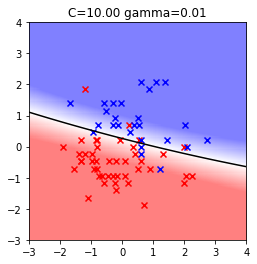

In [9]:
from sklearn.model_selection import GridSearchCV

cv = KFold(n_splits=3)
param_grid = dict(gamma=gamma_range,C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid,verbose=1,cv=cv)
grid.fit(X_train, y_train)

plot_data(X_train, y_train)
plot_decision_function(grid.best_estimator_)
plt.title('C='+str("%.2f" % grid.best_params_['C'])+' gamma='+str("%.2f" % grid.best_params_['gamma']))
print('The best parameters are %s with a score of %0.2f' % (grid.best_params_,grid.best_score_))
# Your code here. Aim for 6-10 lines.

(Optional) You may also want to:
* print the validation score (accuracy, by default) of the best-performing hyperparameters by printing the **best_score_** attribute, and
* inspect the best parameters using the **best_params_** attribute.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Exercise 2.3 &mdash; Random hyperparameter search

Grid Hyperparameter search can be seen as an exhuastive search approach to find the best model congifuration. However, it is not necessar the best, especially in terms of computation efficiency. Thus, random hyperparameter search has been applied widely in various research studies.

**<u>Random hyerperarameter search</u>** does not take a list of grid values, but instead takes distributions that it samples hperparameters from.  

Thus, using a properly distribution for sampling the hyperparameters would be very important. For example, if we sampled from a uniform distribution ([scipy.stats.uniform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html)) in range $[1, 1000]$, there's only a 1\% chance that we'd sample a value between $1$ and $10$. Instead, we can sample from the *reciprocal* distribution ([scipy.stats.reciprocal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.reciprocal.html)) which has logarithmic spacing between samples. A reciprocal distribution over range $[1, 1000]$ has the same chance of drawing a sample in range $[1, 10]$ as it does in range $[10, 100]$ or in range $[100, 1000]$. It is therefore also called a *log uniform* distribution.

**Run the code cell below** to see the differences between sampling values from uniform and reciprocal distribution.

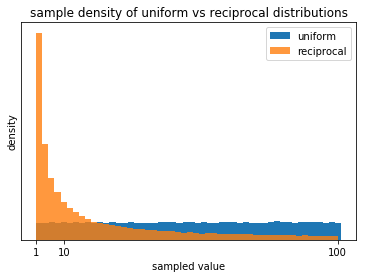

In [10]:
# Create two objects, each representing a different random distribution
reciprocal_distribution = scipy.stats.reciprocal(1, 100)  # Reciprocal distribution in range [0,100]
uniform_distribution = scipy.stats.uniform(1, 100)        # Uniform distribution in range [0,100]

# Draw 100,000 samples from each of the distributions
np.random.seed(0)
reciprocal_samples = reciprocal_distribution.rvs(100000);
uniform_samples = uniform_distribution.rvs(100000);

# Plot the density of samples from each distribution.
plt.hist(uniform_samples, bins=50, label='uniform')
plt.hist(reciprocal_samples, bins=50, label='reciprocal', alpha=0.8);
plt.xticks([1, 10, 100])
plt.yticks([])
plt.xlabel('sampled value')
plt.ylabel('density')
plt.title("sample density of uniform vs reciprocal distributions")
plt.legend();

In the code cell below, use **[sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)** to do a random hyperparameter search.

In particular, you should do the following steps:
1. Define the *param_distribution* argument of *RandomizedSearchCV*. This is similar to the *param_grid* you defined in Exercise 2.2 but, instead of specifying grid values, specify a reciprocal distribution to sample each hyperparameter from. 
2. Use *RandomizedSearchCV* to perform random hyperparameter search with 3-fold cross validation. The *RandomizedSearchCV* object will then draw a sample from each of those distributions when evaluating the next hyperparameters.
  * Use argument *random_state*=0, *verbose*=1
  * Set *n_iter*=16 in order to match the number of hyperparameters you evaluated with your 4x4 grid search.

3. Print the best hyperparameters you found.
4. Plot the data (use *plot_data*) and the best SVM model (use *plot_decision_function*).

Your plot should look something like this:
![image](img/random-search-niter-50.png)

If your decision boundary looks more complex than the above plot, try increasing the *n_iter* parameter, because 16 random hyperparameter settings may not be enough to find a setting that has a good cross validation score.

Fitting 3 folds for each of 16 candidates, totalling 48 fits
The best parameters are {'gamma': 0.04501005970197868, 'C': 10.688443272288106} with a score of 0.81%


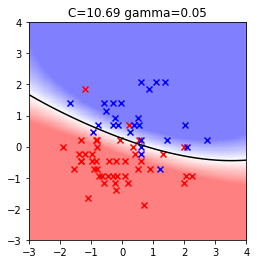

In [11]:
from sklearn.model_selection import RandomizedSearchCV
cv = KFold(n_splits=3)

reciprocal_distribution = scipy.stats.reciprocal(0.01, 10, scale=1)
gamma_range = reciprocal_distribution.rvs(4)
reciprocal_distribution = scipy.stats.reciprocal(1, 1000, scale=1)
C_range = reciprocal_distribution.rvs(4)
random_grid = RandomizedSearchCV(SVC(),dict(gamma=gamma_range,C=C_range),
                                 random_state=0, verbose=1,cv=cv,n_iter=16).fit(X_train, y_train)

plot_data(X_train, y_train)
plot_decision_function(random_grid.best_estimator_)
plt.title('C='+str("%.2f" % random_grid.best_params_['C'])+' gamma='+str("%.2f" % random_grid.best_params_['gamma']))
print('The best parameters are %s with a score of %0.2f' % (random_grid.best_params_,random_grid.best_score_)+'%')
# Your code here. Aim for 8-10 lines.

**Supplementary exercise:** After you have random search working with a *reciprocal* distribution, try changing the distribution to be *uniform* over the same range. Does this help or harm the ability of random search to find a good hyperparameter setting? 

Fitting 3 folds for each of 16 candidates, totalling 48 fits
The best parameters are {'gamma': 1.9451406042007613, 'C': 692.1726713673233} with a score of 0.79%


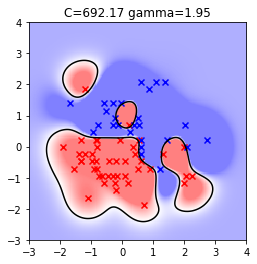

In [12]:
from sklearn.model_selection import RandomizedSearchCV
cv = KFold(n_splits=3)

uniform_distribution = scipy.stats.uniform(0, 10)
gamma_range = uniform_distribution.rvs(4)

uniform_distribution = scipy.stats.uniform(0, 1000)
C_range = uniform_distribution.rvs(4)

uniform_grid = RandomizedSearchCV(SVC(),dict(gamma=gamma_range,C=C_range),
                                  random_state=0, verbose=1,cv=cv,n_iter=16).fit(X_train, y_train)

plot_data(X_train, y_train)
plot_decision_function(uniform_grid.best_estimator_)
plt.title('C='+str("%.2f" % uniform_grid.best_params_['C'])+' gamma='+str("%.2f" % uniform_grid.best_params_['gamma']))
print('The best parameters are %s with a score of %0.2f' % (uniform_grid.best_params_,uniform_grid.best_score_)+'%')

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

### Exercise 2.4 &mdash; Evaluate hyperparameter performance on held-out test data

After hyperparameter search is completed and the final hyperparameters are chosen, you can now do the final evaluation on the model performance using a **held-out test set** if one is available. You explicitly held out a test set ($\mathbf{X}_\text{test}, \mathbf{y}_\text{test}$) in Exercise 1.2, so use that data here.

Using your *GridSearchCV* and *RandomSearchCV* objects from Exercises 2.2 and 2.3 respectively, print the training accuracy and test accuracy of the "best estimator" found by each.
* Use the **best_estimator_** attribute to retrive a model that was trained on *all* the training data using the *best* hyperparameters (the hyperparameters with best average validation performance).
* Use **sklearn.metrics.accuracy_score** or the **score** method on the search object (which uses the *best_estimator_*) to compute the accuracy on the training data and on the test data.

Your output should look like:
```
grid search:
  XX.X% train accuracy
  XX.X% test accuracy
random search:
  XX.X% train accuracy
  XX.X% test accuracy
```
*Tip:* Remember that if you want to print a `%` symbol when formatting a string, you must put `%%` in the original string so that Python knows it's not the start of a format specification (like `%d` or `%.2f`).

In [13]:
print('grid search:')

print('%0.2f'% (grid.best_estimator_.score(X_train, y_train)*100)+'%'+' train accuracy')
print('%0.2f'% (grid.best_estimator_.score(X_test, y_test)*100)+'%'+' test accuracy')

print()
print('random search:')

print('%0.2f'% (random_grid.best_estimator_.score(X_train, y_train)*100)+'%'+' train accuracy')
print('%0.2f'% (random_grid.best_estimator_.score(X_test, y_test)*100)+'%'+' test accuracy')
# Your code here. Aim for 8-10 lines.

grid search:
88.57% train accuracy
76.67% test accuracy

random search:
88.57% train accuracy
80.00% test accuracy
